In [2]:
import pinocchio as pin
import numpy as np
import torch
from torch.autograd.functional import jacobian
import hppfcl
import copy
import crocoddyl as croc
import time
import example_robot_data
import matplotlib.pyplot as plt
from diffsim.shapes import Ellipsoid, Plane 
from pinocchio.visualize import MeshcatVisualizer
from diffsim.collision_pairs import CollisionPairPlaneEllipsoid
from diffsim.utils_render import init_viewer_ellipsoids
from diffsim.simulator import Simulator, SimulatorNode
from tqdm import trange, tqdm
from pathlib import Path
import os
import imageio

In [3]:
from utils.utils import make_video, createSoloModel

In [4]:
path_curr = Path().cwd()

In [5]:
rmodel, rgeomModel, rdata, rgeom_data, ddl = createSoloModel()

In [6]:
rgeomModel.geometryObjects[-1].placement

  R =
1 0 0
0 1 0
0 0 1
  p =     0 0.008 -0.16

In [7]:
rmodel.qref
pin.forwardKinematics(rmodel,rdata,rmodel.qref)
pin.updateGeometryPlacements(rmodel,rdata,rgeomModel,rgeom_data)
rgeom_data.oMg[-1].translation[2]

0.019102751730829468

In [8]:
rmodel.referenceConfigurations["standing"]

array([ 0.   ,  0.   ,  0.235,  0.   ,  0.   ,  0.   ,  1.   ,  0.1  ,
        0.8  , -1.6  , -0.1  ,  0.8  , -1.6  ,  0.1  , -0.8  ,  1.6  ,
       -0.1  , -0.8  ,  1.6  ])

In [9]:
theta =  0# np.pi /6
c,s = np.cos(theta), np.sin(theta)
rty = np.array([[c,0.,s],
               [0.,1.,0.],
               [-s,0.,c]])
n = np.array([s,0.,c])
tx, ty =  np.array([c,0.,-s]), np.array([0.,1.,0.])
gpo = pin.SE3(rty,np.matrix([0.,0.,0.]).T)
q_init = rmodel.qref

v_init = np.zeros(rmodel.nv)
pin.forwardKinematics(rmodel, rdata, q_init)
pin.updateGeometryPlacements(rmodel, rdata, rgeomModel, rgeom_data)

q0 = q_init
dq0 = pin.difference(rmodel, rmodel.qref, q0)
dqrobot0Ref = dq0[:rmodel.nv-6].copy()
v0 = np.zeros(rmodel.nv) 
#v0[rmodel.nv-6:] = np.zeros(6)
x0 = np.zeros(2*rmodel.nv)
x0[:rmodel.nv] = dq0
x0[rmodel.nv:] = v0
dqtarget = torch.tensor(dq0)
dqtarget[2] += .15
dqtarget = dqtarget.detach().numpy()
vtarget = v0.copy()

In [10]:
coeff_friction = 0.7
coeff_rest = 0.0
dt = 5e-3
dqtarget

array([0.  , 0.  , 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [11]:
name = "solo_on_floor"
viz = init_viewer_ellipsoids(rmodel, rgeomModel, open=False)
viz.display(q_init)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


## Making solo jump

In [38]:
T = 20

sim_nodes = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, steps_contact_cascade = 20, dt_collision=dt, k_baumgarte=10*dt))]*T
N_iter = int(25)
ddl=rmodel.nv-6

u_init = np.load("utils/solo12_quasistatic_u.npy")
print(u_init)
u_init = torch.tensor(np.tile(u_init,(T,1))).requires_grad_(False)

u = u_init.clone().requires_grad_(True)

optimizer = torch.optim.Adam([u], lr = .2 )#betas=(1*0.9,1*0.999))
#optimizer = torch.optim.SGD([u], lr = 0.1, momentum=0.)
positions = []
forces_values = []
loss_values = []
contact_forces = np.zeros((T,))

[-0.38456541  0.07671317  0.66555398  0.38701428  0.07681585  0.66239514
 -0.38456946 -0.07674552 -0.6655516   0.38701132 -0.0767835  -0.66239746]


In [39]:
torch.autograd.set_detect_anomaly(False)
N_samples, noise_intensity = 32, 1e-1
N_samples, noise_intensity = 4, 1e-3
positions = np.zeros((N_iter,T,rmodel.nv))
forces_values = np.zeros((N_iter,T,ddl))
for i in trange(N_iter): 
    #sim_nodes = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, dt_collision=dt))]*T
    v, q = torch.tensor(v_init), torch.tensor(q_init)
    xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
    #positions += [np.array([[]])]
    #forces_values += [np.array([[]])]
    for t in range(T):
        u_noise = torch.normal(torch.zeros(T,ddl,N_samples))
        xnext_int = torch.zeros_like(xnext)
        for N in range(N_samples):
            t_tau = torch.zeros_like(v)
            t_tau[6:] = u[t,:] +  noise_intensity* u_noise[t,:,N]
            xnext_sample = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=True)
            xnext_int += xnext_sample
        xnext = xnext_int/N_samples
        positions[i,t,:] = xnext[:rmodel.nv].detach().numpy()
        forces_values[i,t,:] = u[t].detach().numpy()
    loss = 5*torch.square(xnext[2]- dqtarget[2]).sum() + 1e-7*torch.square(u - u_init).sum()
    loss += 1e-2*torch.square(xnext[6:rmodel.nv] - torch.from_numpy(dqtarget[6:rmodel.nv])).sum() 
    
    loss_values += [loss.detach().item()]
     #0*torch.square(xnext[6:rmodel.nv] - torch.from_numpy(dqtarget[6:rmodel.nv])).sum() 
    #forces_values += [sum(u).detach().item()/.001]
    optimizer.zero_grad()
    loss.backward()
    #print(u.grad)
    optimizer.step()
    
os.makedirs(path_curr/'logs'/'solo_jumping', exist_ok=True)
torch.save(u,path_curr/'logs'/'solo_jumping'/'u.pt')

100%|███████████████████████████████████████████| 25/25 [00:58<00:00,  2.33s/it]


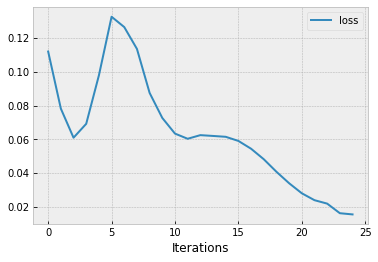

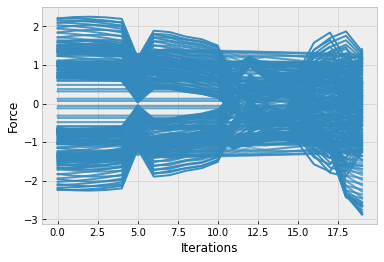

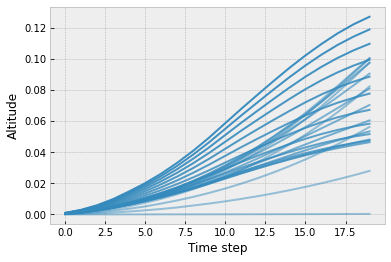

In [40]:
plt.style.use('bmh')
plt.figure()
plt.plot([i for i in range(len(loss_values))], loss_values, label="loss")
plt.xlabel("Iterations")
plt.ylabel("")
plt.legend()
plt.show()

plt.figure()
for j in range(N_iter):
    plt.plot([i for i in range(forces_values.shape[1])], forces_values[j], alpha = .97**(N_iter-j), color = '#348ABD')
plt.xlabel("Iterations")
plt.ylabel("Force")
#plt.legend()
plt.show()

plt.figure()
for j in range(N_iter):
    #plt.plot([i for i in range(N_iter)], forces_values[j], label= "u", alpha = .9**(N_iter-j))
    plt.plot([i for i in range(positions.shape[1])], positions[j,:,2], alpha = .97**(N_iter-j), color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
#plt.legend()
plt.show()

In [41]:
traj = np.zeros((T+1,rmodel.nq))
contact_forces = []
xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
u = torch.load(path_curr/'logs'/'solo_jumping'/'u.pt')
#u = u_init
v, q = torch.tensor(v_init), torch.tensor(q_init)
pattes_positions = []
acc_com = []
masstot = 0
for bodymass in rmodel.inertias.tolist():
    masstot += bodymass.mass
traj[0,:] = rmodel.qref
for t in range(T):
    t_tau = torch.zeros_like(v)
    t_tau[6:] = u[t]
    xnext = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=False)
    pin.updateGeometryPlacements(rmodel, sim_nodes[t].rdata, rgeomModel, rgeom_data)
    traj[t+1,:] = pin.integrate(rmodel, rmodel.qref,xnext[:rmodel.nv].detach().numpy())
    contact_forces += [sim_nodes[t].rdata.contact_forces]
    acc_com += [sum(sim_nodes[t].rdata.contact_forces[:,2])/(masstot*dt) - 9.81]
    pattes_positions += [np.array([rgeom_data.oMg[-1].translation[2], rgeom_data.oMg[-2].translation[2], rgeom_data.oMg[-3].translation[2], rgeom_data.oMg[-4].translation[2]])]

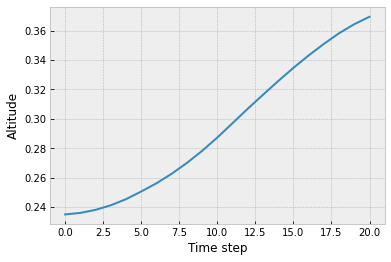

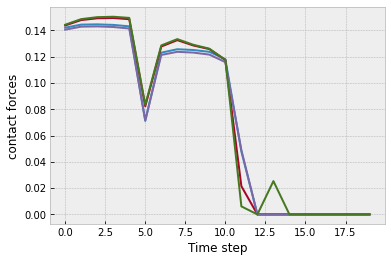

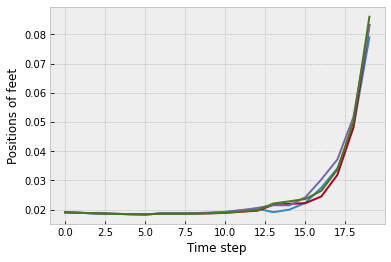

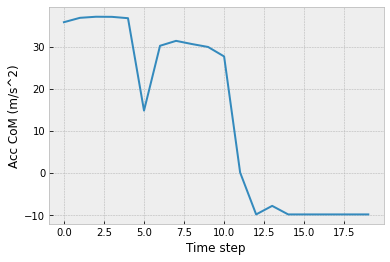

In [42]:
plt.figure()
plt.plot([i for i in range(traj.shape[0])], traj[:,2], color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
#plt.legend()
plt.show()

plt.figure()
for k in range(contact_forces[0].shape[0]):
    plt.plot([i for i in range(len(contact_forces))], [contact_force[k,2] for contact_force in contact_forces])
plt.xlabel("Time step")
plt.ylabel("contact forces")
#plt.legend()
plt.show()

plt.figure()
for k in range(pattes_positions[0].shape[0]):
    plt.plot([i for i in range(len(pattes_positions))], [patte_position[k] for patte_position in pattes_positions])
plt.xlabel("Time step")
plt.ylabel("Positions of feet")
#plt.legend()
plt.show()

plt.figure()
plt.plot([i for i in range(len(acc_com))], acc_com, color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Acc CoM (m/s^2)")
#plt.legend()
plt.show()


In [43]:
viz.display(q_init)
input()
#time.sleep(1.)
for t in range(T+1):
    viz.display(traj[t])
    time.sleep(.2)

In [44]:
fps = 5.
os.makedirs(path_curr/'videos'/'solo_jumping', exist_ok=True)
make_video(viz, np.concatenate((np.expand_dims(q_init,axis=0),traj), axis = 0), path_curr/'videos'/'solo_jumping'/'RSGD.mp4', fps)

generating frames


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.75it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (967, 400) to (976, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55625da3d3c0] Warning: data is not aligned! This can lead to a speed loss


## Jump and land

In [144]:
T = 100
dqtarget = dq0.copy()
dqtarget[2] += .10

sim_nodes = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, steps_contact_cascade = 20, dt_collision=dt, k_baumgarte=10*dt))]*T
N_iter = int(50)
ddl=rmodel.nv-6

u_init = np.load("utils/solo12_quasistatic_u.npy")
u_init = torch.tensor(np.tile(u_init,(T,1))).requires_grad_(False)

u = u_init.clone().requires_grad_(True)

optimizer = torch.optim.Adam([u], lr = .001 )#betas=(1*0.9,1*0.999))
#optimizer = torch.optim.SGD([u], lr = 0.1, momentum=0.)
positions = []
forces_values = []
loss_values = []
contact_forces = np.zeros((T,))

In [145]:
torch.autograd.set_detect_anomaly(False)
N_samples, noise_intensity = 32, 1e-1
N_samples, noise_intensity = 1, .0*1e-3
positions = np.zeros((N_iter,T,rmodel.nv))
forces_values = np.zeros((N_iter,T,ddl))
for i in trange(N_iter): 
    #sim_nodes = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, dt_collision=dt))]*T
    v, q = torch.tensor(v_init), torch.tensor(q_init)
    xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
    #positions += [np.array([[]])]
    #forces_values += [np.array([[]])]
    for t in range(T):
        u_noise = torch.normal(torch.zeros(T,ddl,N_samples))
        xnext_int = torch.zeros_like(xnext)
        for N in range(N_samples):
            t_tau = torch.zeros_like(v)
            t_tau[6:] = u[t,:] +  noise_intensity* u_noise[t,:,N]
            xnext_sample = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=True)
            xnext_int += xnext_sample
        xnext = xnext_int/N_samples
        positions[i,t,:] = xnext[:rmodel.nv].detach().numpy()
        forces_values[i,t,:] = u[t].detach().numpy()
        if t == T//2:
            loss = 5*torch.square(xnext[2]- dqtarget[2]).sum() 
            loss += 1e-2*torch.square(xnext[6:rmodel.nv] - torch.from_numpy(dqtarget[6:rmodel.nv])).sum()
    #loss += 500*torch.square(xnext[:rmodel.nv]- torch.from_numpy(dq0)).sum() + 5e-7*torch.square(u - u_init).sum()
    
    loss_values += [loss.detach().item()]
     #0*torch.square(xnext[6:rmodel.nv] - torch.from_numpy(dqtarget[6:rmodel.nv])).sum() 
    #forces_values += [sum(u).detach().item()/.001]
    optimizer.zero_grad()
    loss.backward()
    #print(u.grad)
    optimizer.step()
    
os.makedirs(path_curr/'logs'/'solo_jumping_landing', exist_ok=True)
torch.save(u,path_curr/'logs'/'solo_jumping_landing'/'u.pt')

100%|███████████████████████████████████████████| 50/50 [01:48<00:00,  2.17s/it]


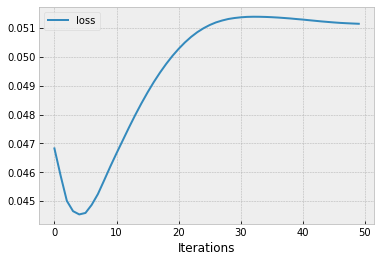

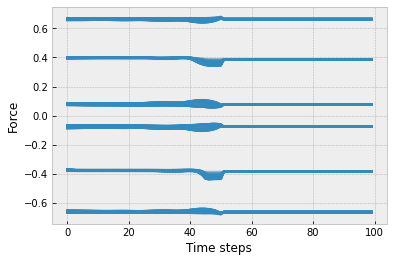

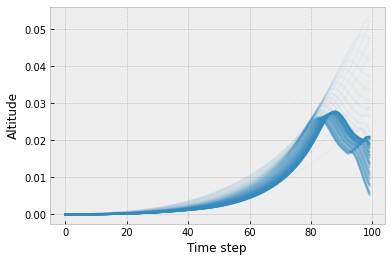

In [146]:
plt.style.use('bmh')
plt.figure()
plt.plot([i for i in range(len(loss_values))], loss_values, label="loss")
plt.xlabel("Iterations")
plt.ylabel("")
plt.legend()
plt.show()

plt.figure()
for j in range(N_iter):
    plt.plot([i for i in range(forces_values.shape[1])], forces_values[j], alpha = .93**(N_iter-j), color = '#348ABD')
plt.xlabel("Time steps")
plt.ylabel("Force")
#plt.legend()
plt.show()

plt.figure()
for j in range(N_iter):
    #plt.plot([i for i in range(N_iter)], forces_values[j], label= "u", alpha = .9**(N_iter-j))
    plt.plot([i for i in range(positions.shape[1])], positions[j,:,2], alpha = .93**(N_iter-j), color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
#plt.legend()
plt.show()

In [141]:
traj = np.zeros((T+1,rmodel.nq))
contact_forces = []
xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
u = torch.load(path_curr/'logs'/'solo_jumping_landing'/'u.pt')
#u = u_init
v, q = torch.tensor(v_init), torch.tensor(q_init)
pattes_positions = []
acc_com = []
masstot = 0
for bodymass in rmodel.inertias.tolist():
    masstot += bodymass.mass
traj[0,:] = rmodel.qref
for t in range(T):
    t_tau = torch.zeros_like(v)
    t_tau[6:] = u[t]
    xnext = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=False)
    pin.updateGeometryPlacements(rmodel, sim_nodes[t].rdata, rgeomModel, rgeom_data)
    traj[t+1,:] = pin.integrate(rmodel, rmodel.qref,xnext[:rmodel.nv].detach().numpy())
    contact_forces += [sim_nodes[t].rdata.contact_forces]
    acc_com += [sum(sim_nodes[t].rdata.contact_forces[:,2])/(masstot*dt) - 9.81]
    pattes_positions += [np.array([rgeom_data.oMg[-1].translation[2], rgeom_data.oMg[-2].translation[2], rgeom_data.oMg[-3].translation[2], rgeom_data.oMg[-4].translation[2]])]

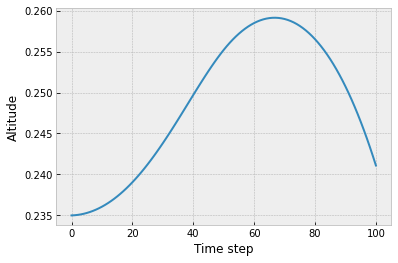

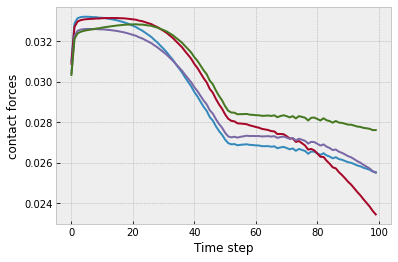

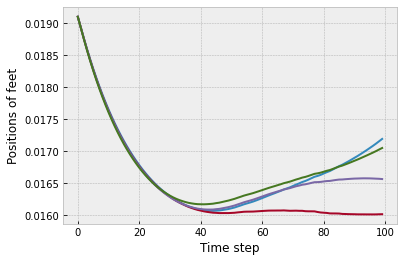

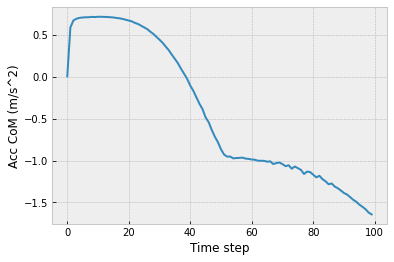

In [142]:
plt.figure()
plt.plot([i for i in range(traj.shape[0])], traj[:,2], color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
#plt.legend()
plt.show()

plt.figure()
for k in range(contact_forces[0].shape[0]):
    plt.plot([i for i in range(len(contact_forces))], [contact_force[k,2] for contact_force in contact_forces])
plt.xlabel("Time step")
plt.ylabel("contact forces")
#plt.legend()
plt.show()

plt.figure()
for k in range(pattes_positions[0].shape[0]):
    plt.plot([i for i in range(len(pattes_positions))], [patte_position[k] for patte_position in pattes_positions])
plt.xlabel("Time step")
plt.ylabel("Positions of feet")
#plt.legend()
plt.show()

plt.figure()
plt.plot([i for i in range(len(acc_com))], acc_com, color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Acc CoM (m/s^2)")
#plt.legend()
plt.show()


In [143]:
viz.display(q_init)
input()
#time.sleep(1.)
for t in range(T+1):
    viz.display(traj[t])
    time.sleep(.2)

In [44]:
fps = 5.
os.makedirs(path_curr/'videos'/'solo_jumping_landing', exist_ok=True)
make_video(viz, np.concatenate((np.expand_dims(q_init,axis=0),traj), axis = 0), path_curr/'videos'/'solo_jumping_landing'/'RSGD.mp4', fps)

generating frames


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 12.75it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (967, 400) to (976, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55625da3d3c0] Warning: data is not aligned! This can lead to a speed loss


## Using DDP with smoothed physics

In [96]:
class SmoothActionModel(croc.ActionModelAbstract):
    def __init__(self, state, simulator, jointCube, ptarget1 , cw1, cw2, dqrobot0Ref, noiseIntensity, nbSamples, terminal=False):
        self.sim = simulator
        self.ptarget1 = ptarget1
        self.terminal = terminal
        self.dqrobot0Ref = dqrobot0Ref
        self.t_dqrobot0Ref = torch.from_numpy(dqrobot0Ref)
        self.jointCube = jointCube
        self.costWeight1 = cw1
        self.costWeight2 = cw2
        self.costWeightAction = 1e0
        self.costReg = 5e-7
        self.nv = self.sim.rmodel.nv 
        self.noiseIntensity = noiseIntensity
        self.nbSamples = nbSamples
        nu = 8
        nr = 1
        self.unone = np.zeros(self.nv)
        croc.ActionModelAbstract.__init__(self, state, nu, nr)

    def createData(self):
        data = croc.ActionModelAbstract.createData(self)
        data.node = SimulatorNode(self.sim)
        return data
    
    def calc(self, data, x, u=None, uNoise = None):
        if u is None:
            u = self.unone
        if uNoise is None:
            uNoise = torch.zeros((self.nbSamples, u.shape[0]))
        t_x = torch.from_numpy(x)
        t_xnext = torch.zeros_like(t_x)
        for ui in uNoise:
            t_tau = torch.zeros(self.nv)
            t_tau[6:] = torch.tensor(u) + ui
            t_xnexti = data.node.makeStep(t_x, t_tau, calcPinDiff=False)
            t_xnext += t_xnexti
        t_xnext /= self.nbSamples
        if self.terminal:
            x_tar = torch.zeros_like(t_xnext)
            x_tar[2] = self.ptarget1[2]
            t_res1 = self.costWeight1*(t_xnext - x_tar)
        else:
            t_res1 = torch.zeros_like(t_xnext)
        data.xnext[:] = t_xnext.detach().numpy()
        data.r[0] = self.costWeight1 * (t_xnext.detach().numpy()[2] - self.ptarget1[2])
        data.cost =  0.5 * sum(data.r**2)
        return data.xnext, data.cost


    def calcDiff(self, data, x, u=None):
        if u is None:
            u = self.unone
        xnext, cost = self.calc(data, x, u)
        t_x = torch.from_numpy(x).requires_grad_(True)
        t_u = torch.from_numpy(u).requires_grad_(True)
        def calcTorch(t_x, t_u):
            t_xnext = torch.zeros_like(t_x)
            uNoise = self.noiseIntensity*torch.randn((self.nbSamples, t_u.size()[0]))
            for i in range(self.nbSamples): 
                t_tau = torch.zeros(self.nv)
                t_tau[6:] = t_u + uNoise[i]
                t_xnexti = data.node.makeStep(t_x, t_tau, calcPinDiff=True)
                t_xnext += t_xnexti
            t_xnext /= self.nbSamples 
            if self.terminal:
                x_tar = torch.zeros_like(t_xnext)
                x_tar[2] = self.ptarget1[2]
                t_res1 = self.costWeight1*(t_xnext[2] - x_tar[2]).unsqueeze(0)
            else:
                t_res1 = self.costWeight1 *torch.zeros_like(t_xnext)
            t_res_reg =  torch.tensor([0.]) 
            t_res_u = self.costWeight2*self.costWeightAction * t_u
            t_res = torch.cat([t_res1, t_res_u, t_res_reg])
            t_cost = 0.5 * torch.sum(t_res * t_res)
            return t_xnext, t_cost
        
        J = torch.autograd.functional.jacobian(calcTorch, (t_x, t_u))
        data.Fx[:] = J[0][0].numpy()
        data.Fu[:] = J[0][1][:].numpy()
        if np.linalg.norm(data.Fu[:])<1e-9:
            data.Fu[:] = 0
        data.Lx[:] = J[1][0].numpy()
        data.Lu[:] = J[1][1].numpy()
        return xnext, cost

In [105]:
robotModel = rmodel.copy()
robotData = robotModel.createData()
q = q0
T = 100
dt = 5e-3
state = croc.StateVector(2*rmodel.nv)
ug = pin.computeGeneralizedGravity(robotModel, robotData, q)
jointBaseId = 1
sim = Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, dt_collision=dt, steps_contact_cascade=10)
actionModel1 = SmoothActionModel(state, sim, jointBaseId, dqtarget[:3], 0, 5., dqrobot0Ref, 5e0, 8, terminal=False)
actionModelTerminal = SmoothActionModel(state, sim, jointBaseId, dqtarget[:3], 1000., 5., dqrobot0Ref,5e0, 8, terminal=True)
problem = croc.ShootingProblem(x0, [actionModel1]*T,
                               actionModelTerminal)

ddp = croc.SolverFDDP(problem)
log = croc.CallbackLogger()
ddp.setCallbacks([log, croc.CallbackVerbose()])

In [106]:
init_us = [ug[6:]*0.] * T
init_xs = problem.rollout(init_us)
done = ddp.solve(init_xs, init_us, 20)
print(done)

.47910e+04  2.58861e+10  1.00000e-07  1.00000e-07   0.0020     0
   2  5.00004e+03  8.47910e+04  8.09840e+16  1.00000e-06  1.00000e-06   0.0020     0
   3  5.00004e+03  8.47910e+04  1.58215e+08  1.00000e-05  1.00000e-05   0.0020     0
   4  5.00004e+03  8.47910e+04  -2.25578e+06  1.00000e-04  1.00000e-04   0.0020     0
   5  5.00004e+03  8.47910e+04  -6.50066e+05  1.00000e-03  1.00000e-03   0.0020     0
   6  5.00004e+03  8.47910e+04  1.58086e+05  1.00000e-02  1.00000e-02   0.0020     0
   7  5.00004e+03  8.47910e+04  1.58086e+04  1.00000e-01  1.00000e-01   0.0020     0
   8  4.13566e+03  8.47910e+04  1.58086e+03  1.00000e-01  1.00000e-01   0.1250     0
   9  4.13566e+03  1.10797e+11  2.10141e+09  1.00000e+00  1.00000e+00   0.0020     0
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  4.13566e+03  1.10797e+11  2.10141e+08  1.00000e+01  1.00000e+01   0.0020     0
  11  4.13566e+03  1.10797e+11  2.10141e+07  1.00000e+02  1.00000e+02   0.0020     0
  12  4.13566e+

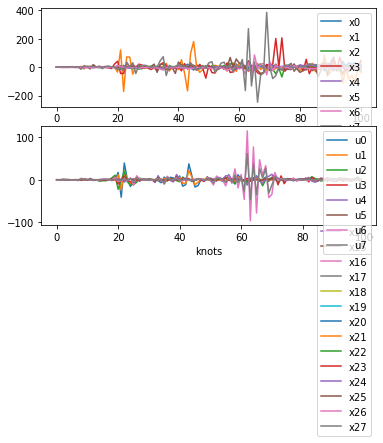

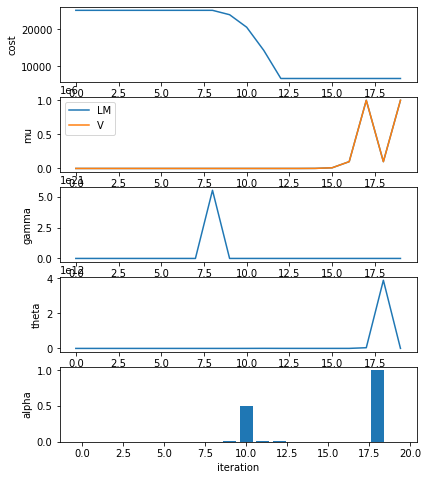

In [107]:
croc.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
croc.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)

In [102]:
traj = np.zeros((T,rmodel.nq))
contact_forces = []
xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
u_init = (torch.ones((T,ddl))*0.)
u = torch.tensor(ddp.us.tolist())
pattes_positions = []
acc_com = []
sim_nodes = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, dt_collision=dt))]*T
masstot = 0
for bodymass in rmodel.inertias.tolist():
    masstot += bodymass.mass
for t in range(T):
    t_tau = torch.zeros_like(v)
    t_tau[6:] = u[t]
    xnext = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=True)
    pin.updateGeometryPlacements(rmodel, sim_nodes[t].rdata, rgeomModel, rgeom_data)
    traj[t,:] = pin.integrate(rmodel, rmodel.qref,xnext[:rmodel.nv].detach().numpy())
    contact_forces += [sim_nodes[t].rdata.contact_forces]
    acc_com += [sum(sim_nodes[t].rdata.contact_forces[:,2])/(masstot*dt) - 9.81]
    pattes_positions += [np.array([rgeom_data.oMg[13].translation[2], rgeom_data.oMg[14].translation[2], rgeom_data.oMg[15].translation[2], rgeom_data.oMg[16].translation[2]])]

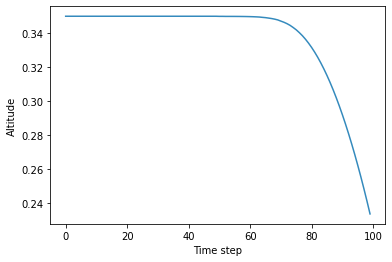

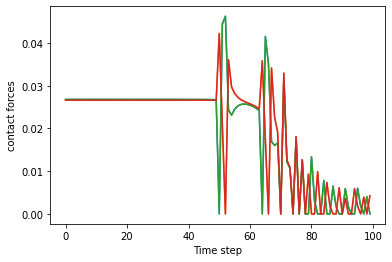

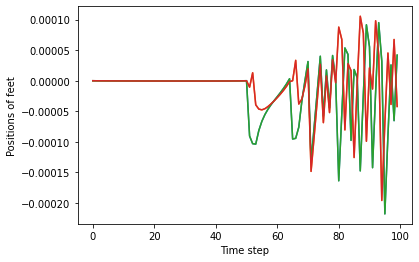

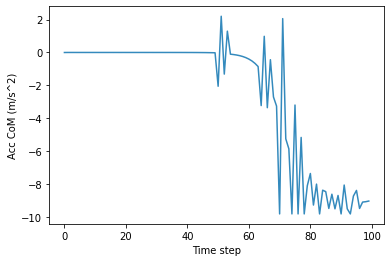

In [103]:
plt.figure()
plt.plot([i for i in range(traj.shape[0])], traj[:,2], color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
plt.show()

plt.figure()
for k in range(contact_forces[0].shape[0]):
    plt.plot([i for i in range(len(contact_forces))], [contact_force[k,2] for contact_force in contact_forces])
plt.xlabel("Time step")
plt.ylabel("contact forces")
plt.show()

plt.figure()
for k in range(pattes_positions[0].shape[0]):
    plt.plot([i for i in range(len(pattes_positions))], [patte_position[k]-0.03 for patte_position in pattes_positions])
plt.xlabel("Time step")
plt.ylabel("Positions of feet")
plt.show()

plt.figure()
plt.plot([i for i in range(len(acc_com))], acc_com, color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Acc CoM (m/s^2)")
plt.show()

In [95]:
os.makedirs(path_curr/'logs'/'solo_jumping', exist_ok=True)
torch.save(us,path_curr/'logs'/'solo_jumping'/'u_ddp.pt')
fps = 5.
os.makedirs(path_curr/'videos'/'solo_jumping', exist_ok=True)
make_video(viz, np.concatenate((np.expand_dims(q_init,axis=0),traj), axis = 0), path_curr/'videos'/'solo_jumping'/'RSDDP.mp4', fps)

  0%|                                                                                                                                             | 0/11 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (967, 400) to (976, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5595fecd93c0] Warning: data is not aligned! This can lead to a speed loss
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 71.73it/s]


In [104]:
viz.display(q_init)
time.sleep(3.)
for t in range(T):
    viz.display(traj[t])
    time.sleep(.2)

## Lift a foot

In [58]:
rmodel, rgeomModel, rdata, rgeom_data = createSoloModel()

In [59]:
theta =  0# np.pi /6
c,s = np.cos(theta), np.sin(theta)
rty = np.array([[c,0.,s],
               [0.,1.,0.],
               [-s,0.,c]])
n = np.array([s,0.,c])
tx, ty =  np.array([c,0.,-s]), np.array([0.,1.,0.])
gpo = pin.SE3(rty,np.matrix([0.,0.,0.]).T)
q_init = rmodel.qref

v_init = np.zeros(rmodel.nv)
pin.forwardKinematics(rmodel, rdata, q_init)
pin.updateGeometryPlacements(rmodel, rdata, rgeomModel, rgeom_data)

q0 = q_init.copy()
q_target = q_init.copy()
q_target[-1] += .9
dq0 = pin.difference(rmodel, rmodel.qref, q0)
dqrobot0Ref = dq0[:rmodel.nv-6].copy()
v0 = np.zeros(rmodel.nv) 
#v0[rmodel.nv-6:] = np.zeros(6)
x0 = np.zeros(2*rmodel.nv)
x0[:rmodel.nv] = dq0
x0[rmodel.nv:] = v0
dqtarget = torch.from_numpy(pin.difference(rmodel, rmodel.qref, q_target))
vtarget = v0.copy()

In [60]:
name = "solo_lift_leg"
viz_lift = init_viewer_ellipsoids(rmodel, rgeomModel, open=False)
viz_lift.display(q_init)
viz_lift.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [241]:
T = 20

sim_nodes = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, steps_contact_cascade = 20, dt_collision=dt, k_baumgarte=.1))]*T
sim_nodes2 = [SimulatorNode( Simulator(rmodel, rgeomModel, dt, coeff_friction, coeff_rest, steps_contact_cascade = 10, dt_collision=dt, k_baumgarte=.1))]*T
N_iter = int(20)
ddl=rmodel.nv-6
adaptive_smoothing = True
theta_ad = .001
N_samples, noise_intensity = 32, 1e-1
N_samples, noise_intensity = 4, 7e-1
alpha = .5

u_init = np.load("utils/solo12_quasistatic_u.npy")
u_init = torch.tensor(np.tile(u_init,(T,1))).requires_grad_(False)

u = u_init.clone().requires_grad_(True)

#optimizer = torch.optim.Adam([u], lr = .01 )#betas=(1*0.9,1*0.999))
optimizer = torch.optim.SGD([u], lr = 0.005, momentum=0.9*0.)

loss_values = []
noise_intensities = []
N_samples_values = []
contact_forces = np.zeros((T,))
positions = np.zeros((N_iter,T,rmodel.nv))
forces_values = np.zeros((N_iter,T,ddl))
gradient_values = np.zeros((N_iter, T, ddl))

In [242]:
def loss_function(rmodel, xnext, u, N_samples, noise_intensity, u_noise=None, adaptive_estimate = False):
    grads_samples = torch.zeros(T,N_samples, 2*rmodel.nv+rmodel.nv, 2*rmodel.nv) if adaptive_estimate else None
    for t in range(T):
        if u_noise is None:
            u_noise = torch.normal(torch.zeros(T,ddl,N_samples))
        xnext_int = torch.zeros_like(xnext)
        for N in range(N_samples):
            t_tau = torch.zeros(rmodel.nv)
            t_tau[6:] = u[t,:] +  noise_intensity* u_noise[t,:,N]
            xnext_sample = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=True)
            if adaptive_estimate:
                inputs = (xnext.detach(), t_tau.detach())
                jaco = jacobian(lambda xnext, t_tau: sim_nodes2[t].makeStep(xnext, t_tau, calcPinDiff=True), inputs)
                grads_samples[t,N,:2*rmodel.nv,:] = jaco[0][0]
                grads_samples[t,N,2*rmodel.nv:,:] = jaco[0][1]
            xnext_int += xnext_sample
        xnext = xnext_int/N_samples
        positions[i,t,:] = xnext[:rmodel.nv].detach().numpy()
        forces_values[i,t,:] = u[t].detach().numpy()
    loss = 7*torch.square(xnext[:rmodel.nv]- dqtarget).sum() + 1e-7*torch.square(u - u_init).sum()
    return loss, u_noise, grads_samples

In [243]:
torch.autograd.set_detect_anomaly(False)
for i in trange(N_iter): 
    v, q = torch.tensor(v_init), torch.tensor(q_init)
    xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
    loss, u_noise, grads_samples = loss_function(rmodel, xnext, u, N_samples, noise_intensity, adaptive_estimate = adaptive_smoothing)
    loss_values += [loss.detach().item()]
    optimizer.zero_grad()
    loss.backward()
    gamma = 2.
    gradient_values[i,:,:] = u.grad.detach().numpy()
    noise_intensities += [noise_intensity]
    N_samples_values += [N_samples]
    alpha *= (gamma**(1/2))
    print("current loss", loss_values[-1])
    while True:
        try_loss, _, _ = loss_function(rmodel, xnext, u - alpha*u.grad, N_samples, noise_intensity, u_noise)
        print("try", try_loss.detach().item())
        print(loss - try_loss, ">", alpha *.1 *torch.square(u.grad).sum())
        if loss - try_loss > alpha *.001 *torch.square(u.grad).sum():
            u.data  = u.data - alpha*u.grad.detach()
            break
        else:
            alpha *= .6
    if adaptive_smoothing:
        #print("grad", grads_samples.size(), grads_samples[10,:,:,:].mean(), grads_samples[10,1,:,:].mean())
        grad_var, grad_mean = torch.var_mean(grads_samples, dim = 1)
        
        #grad_mean = torch.cat((grad_mean[:,:2*rmodel.nv,:],grad_mean[:,2*rmodel.nv+6:,:]),dim = 1)
        grad_mean =grad_mean[:,2*rmodel.nv+6:,:]
        print("mean", grad_mean[:,:,:].mean())
        print(grad_mean[0,:,:])
        grad_mean = torch.square(grad_mean).sum(dim=(-1,-2))
        #grad_var = torch.cat((grad_var[:,:2*rmodel.nv,:], grad_var[:,2*rmodel.nv+6:,:] ), dim =1 )
        grad_var = grad_var[:,2*rmodel.nv+6:,:]
        print("var", grad_var.size(),grad_var[:,:,:].mean())
        print(grad_var[0,:,:])
        grad_var = torch.abs(grad_var).sum(dim = (-1,-2))
        print("mean", grad_mean)
        print("var", grad_var)
        print("adapt", grad_var/N_samples, (theta_ad**2)*grad_mean)
        if torch.any(torch.isnan(grad_var)):
            print(torch.any(grads_samples).isnan(), N_samples)
        if torch.all(grad_var/N_samples > (theta_ad**2)*grad_mean):
            noise_intensity *= .5
        elif torch.all(grad_var/N_samples < (.0005**2)*grad_mean):
            N_samples = max(int(N_samples/2),1)
        
    #optimizer.step()
    
os.makedirs(path_curr/'logs'/'solo_lifting_leg', exist_ok=True)
torch.save(u,path_curr/'logs'/'solo_lifting_leg'/'u.pt')

  0%|                                                                                                                                             | 0/20 [00:00<?, ?it/s]

current loss 25.21799432528231
try 1409.3414741752745
tensor(-1384.1235, grad_fn=<SubBackward0>) > tensor(12.3833)
try 306.0433742850263
tensor(-280.8254, grad_fn=<SubBackward0>) > tensor(7.4300)
try 105.25982605196647
tensor(-80.0418, grad_fn=<SubBackward0>) > tensor(4.4580)


  5%|██████▋                                                                                                                              | 1/20 [00:31<10:06, 31.93s/it]

try 17.72918654863359
tensor(7.4888, grad_fn=<SubBackward0>) > tensor(2.6748)
mean tensor(0.0278)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000])
var torch.Size([20, 12, 36]) tensor(1.0241e-07)
tensor([[1.1491e-07, 1.2747e-13, 1.8025e-06, 5.0296e-09, 1.6487e-09, 4.0057e-10,
         1.0911e-08, 9.9421e-11, 3.3093e-10, 1.0441e-09, 3.7442e-10, 9.0729e-10,
         2.4958e-09, 5.5577e-11, 3.5227e-10, 4.2956e-10, 9.2210e-12, 4.3984e-10,
         2.8687e-11, 2.1965e-09, 4.3300e-11, 1.5401e-10, 5.4462e-12, 2.3126e-11,
         4.7318e-11, 1.3004e-13, 4.1457e-14, 1.0826e-11, 8.4859e-13, 1.6708e-12,
         1.0552e-11, 5.1982e-14, 2.8012e-14, 2.4494e-11, 4.1899e-13, 1.9750e-13],
        [1.1491e-07, 1.2747e-13, 1.8025e-06, 5.0296e-09, 1.6487e-09, 4.0057e-10,
         1.0911e-08, 9.9421e-11, 3.3093e-10, 1.0441e-09, 3.7442e-10, 9.0729e-10,
         2.4958e-09, 5.5577e-11, 3.5227e-10, 4.2956e-10, 9.2210e-12, 4.3984e-10,
         2.

  5%|██████▋                                                                                                                              | 1/20 [00:42<13:22, 42.23s/it]


KeyboardInterrupt: 

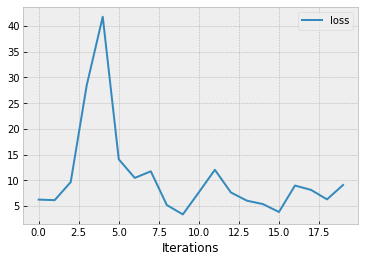

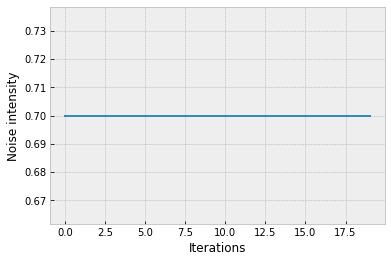

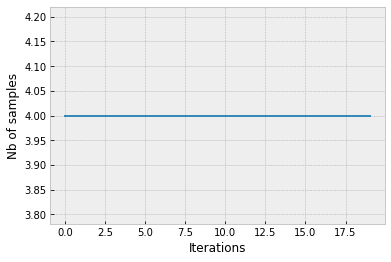

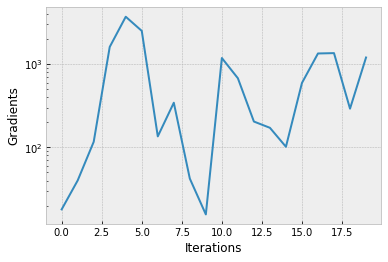

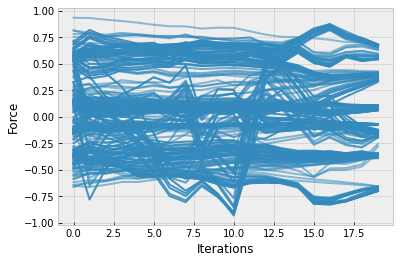

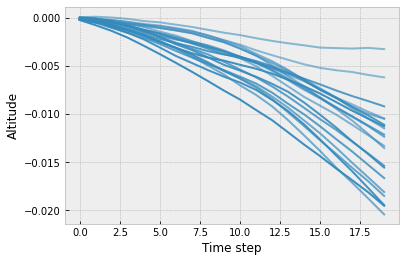

In [192]:
plt.style.use('bmh')
plt.figure()
plt.plot([i for i in range(len(loss_values))], loss_values, label="loss")
plt.xlabel("Iterations")
plt.ylabel("")
plt.legend()
plt.show()

plt.figure()
plt.plot([i for i in range(len(noise_intensities))], noise_intensities)
plt.xlabel("Iterations")
plt.ylabel("Noise intensity")
plt.show()

plt.figure()
plt.plot([i for i in range(len(N_samples_values))], N_samples_values)
plt.xlabel("Iterations")
plt.ylabel("Nb of samples")
plt.show()

plt.figure()
plt.semilogy([i for i in range(gradient_values.shape[0])], np.sum(np.square(gradient_values), axis =(1,2)))
plt.xlabel("Iterations")
plt.ylabel("Gradients")
plt.show()

plt.figure()
for j in range(N_iter):
    plt.plot([i for i in range(forces_values.shape[1])], forces_values[j], alpha = .97**(N_iter-j), color = '#348ABD')
plt.xlabel("Iterations")
plt.ylabel("Force")
#plt.legend()
plt.show()

plt.figure()
for j in range(N_iter):
    #plt.plot([i for i in range(N_iter)], forces_values[j], label= "u", alpha = .9**(N_iter-j))
    plt.plot([i for i in range(positions.shape[1])], positions[j,:,2], alpha = .97**(N_iter-j), color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
#plt.legend()
plt.show()

In [153]:
traj = np.zeros((T+1,rmodel.nq))
contact_forces = []
xnext = torch.cat((torch.tensor(dq0),torch.tensor(v0)), dim=0).detach().clone()
u = torch.load(path_curr/'logs'/'solo_lifting_leg'/'u.pt')
#u = u_init
#u = torch.tensor(force_values[])
pattes_positions = []
acc_com = []
masstot = 0
for bodymass in rmodel.inertias.tolist():
    masstot += bodymass.mass
traj[0,:] = rmodel.qref
for t in range(T):
    t_tau = torch.zeros(rmodel.nv)
    t_tau[6:] = u[t]
    xnext = sim_nodes[t].makeStep(xnext, t_tau, calcPinDiff=False)
    pin.updateGeometryPlacements(rmodel, sim_nodes[t].rdata, rgeomModel, rgeom_data)
    traj[t+1,:] = pin.integrate(rmodel, rmodel.qref,xnext[:rmodel.nv].detach().numpy())
    contact_forces += [sim_nodes[t].rdata.contact_forces]
    acc_com += [sum(sim_nodes[t].rdata.contact_forces[:,2])/(masstot*dt) - 9.81]
    pattes_positions += [np.array([rgeom_data.oMg[-1].translation[2], rgeom_data.oMg[-2].translation[2], rgeom_data.oMg[-3].translation[2], rgeom_data.oMg[-4].translation[2]])]

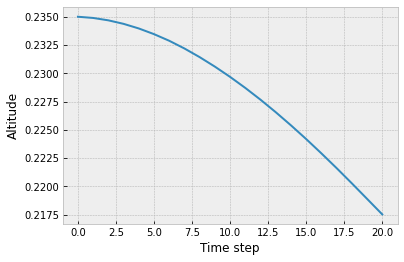

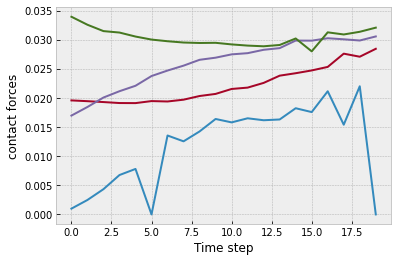

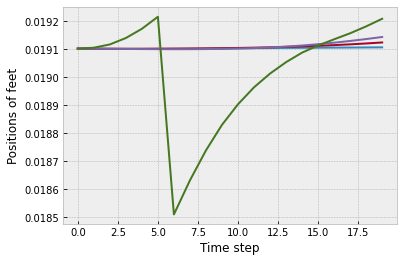

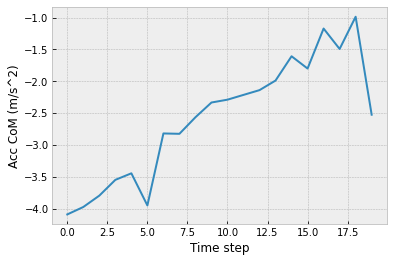

In [154]:
plt.figure()
plt.plot([i for i in range(traj.shape[0])], traj[:,2], color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Altitude")
#plt.legend()
plt.show()

plt.figure()
for k in range(contact_forces[0].shape[0]):
    plt.plot([i for i in range(len(contact_forces))], [contact_force[k,2] for contact_force in contact_forces])
plt.xlabel("Time step")
plt.ylabel("contact forces")
#plt.legend()
plt.show()

plt.figure()
for k in range(pattes_positions[0].shape[0]):
    plt.plot([i for i in range(len(pattes_positions))], [patte_position[k] for patte_position in pattes_positions])
plt.xlabel("Time step")
plt.ylabel("Positions of feet")
#plt.legend()
plt.show()

plt.figure()
plt.plot([i for i in range(len(acc_com))], acc_com, color = '#348ABD')
plt.xlabel("Time step")
plt.ylabel("Acc CoM (m/s^2)")
#plt.legend()
plt.show()

In [155]:
viz_lift.display(q_init)
input()
#time.sleep(1.)
for t in range(T+1):
    viz_lift.display(traj[t])
    time.sleep(.2)

In [97]:
os.makedirs(path_curr/'logs'/'solo_lifting_leg', exist_ok=True)
#torch.save(us,path_curr/'logs'/'solo_lifting_leg'/'u_ddp.pt')
fps = 5.
os.makedirs(path_curr/'videos'/'solo_lifting_leg', exist_ok=True)
make_video(viz_lift, np.concatenate((np.expand_dims(q_init,axis=0),traj), axis = 0), path_curr/'videos'/'solo_lifting_leg'/'ARS-GD-LS.mp4', fps)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 69.50it/s]


In [19]:
viz.display(q_target)